In [7]:
import my_functions as ft
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.dropout1 = nn.Dropout(p=0.7)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(p=0.7)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

g_dataset_name = "BTCUSD_bad_dataset_1H_100candles_balanced" # Name of the zip (without .zip) where the data is stored and without _balanced
g_output_model_name = "BTCUSD_bad_dataset_1H_100candles_balanced_0" # Name of the output model (no .pth)
g_lines_per_file = 16384 # Amount of rows per csv file generated when saving the balanced dataset
g_batch_size = 32 # Amount of rows the model will se before updating its parameters
g_epochs = 250 # Number of times the model will loop through the data
g_learning_rate = 0.001 # Speed at which the model adjusts its parameters
g_train_percentage = 0.8 # Percentage of the whole dataset that goes into train and test (the value is the percentage of train data)
g_seed=42 # Seed for the random number generator
g_num_separations_confusion_matrix = 11 # How many different values will be used to round the predictions in the confusion matrix
g_early_stop_epochs = 50 # Number of epochs without the model improving the loss that stop the training (can be None to never stop)
g_device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use cuda if posible else cpu
g_model = Model(ft.count_columns(f'{g_dataset_name}/{g_dataset_name}_0.csv') - 1).to(g_device) # Model to be trained
g_loss_function= nn.BCELoss() # Binary Cross Entropy Loss
g_optimizer = optim.Adam(g_model.parameters(), lr=g_learning_rate) # Adam optimizer
g_metric_function = None # Function to calculate some metrics of the model when testing
g_plot_metrics_function = None # Function to plot the metrics of the model when testing
g_debug_msg_interval = 10 # How many epochs between print messages of the loss

def metric_function(output, y_batch): # Function to calculate some metrics of the model when testing
    pass
def plot_metrics_function(metrics): # Function to plot the metrics of the model when testing
    pass

## Generate the loaders

In [2]:
# If no balanced dataset is found, try to generate it from the unbalanced dataset
if g_dataset_name.endswith('_balanced')\
	and not os.path.exists(g_dataset_name)\
	and not os.path.exists(f'{g_dataset_name}.zip'):
        tmp_unbalanced_dataset_name = g_dataset_name.replace('_balanced', '')
        print(f'Dataset {g_dataset_name}<.zip> not found. Trying to generate from {tmp_unbalanced_dataset_name}<.zip>.')
        g_df = ft.balance_dataset(ft.load_dataset(tmp_unbalanced_dataset_name), seed=g_seed)
        print(f'Saving balanced dataset {g_dataset_name}')
        ft.save_dataset(g_df, g_dataset_name, g_lines_per_file)

g_df = ft.load_dataset(g_dataset_name)

tmp_X = g_df.iloc[:, :-1].values
tmp_y = g_df.iloc[:, -1].values
g_train_loader, g_test_loader = ft.create_data_loaders(
	X=tmp_X,
	y=tmp_y,
	batch_size=g_batch_size,
	train_percentage=g_train_percentage,
	shuffle=True,
	device=g_device,
	random_state=g_seed)

ft.del_tmp_vars()

## Visualize the loaders

Train dataset size: 30081
Test dataset size: 7521
Number of train batches: 941
Number of test batches: 236
Batch size: 32


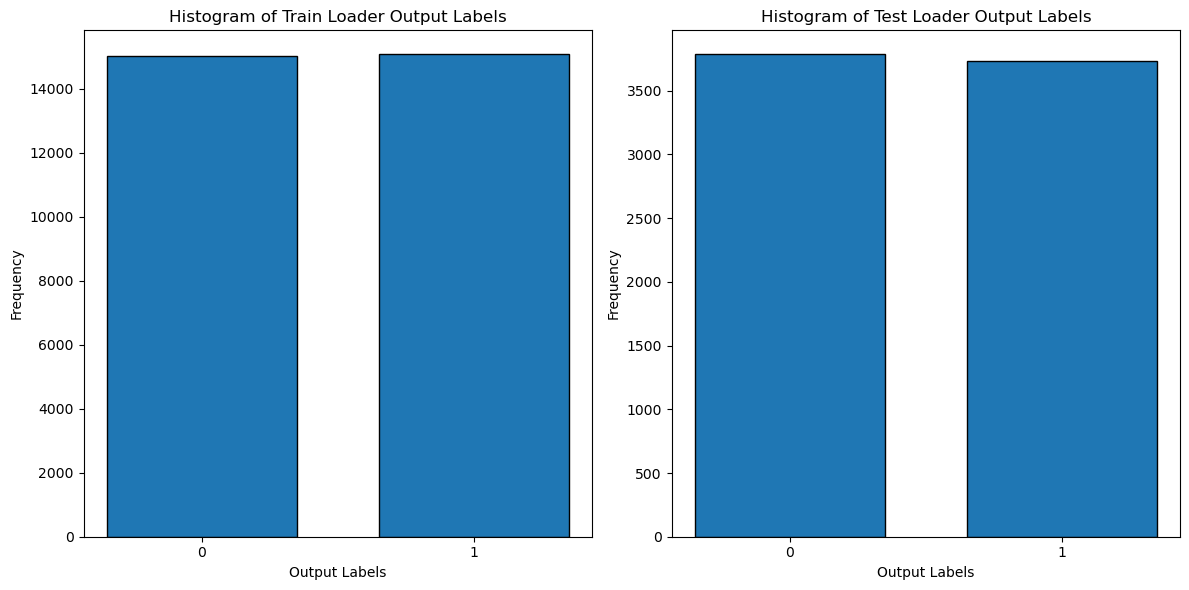

Ratio of 1s to 0s in train_loader: 1.00:1
Ratio of 1s to 0s in test_loader: 0.99:1


In [3]:
# Get the dataset size and number of batches
tmp_train_dataset_size = len(g_train_loader.dataset)
tmp_test_dataset_size = len(g_test_loader.dataset)
tmp_train_batches = len(g_train_loader)
tmp_test_batches = len(g_test_loader)

print(f'Train dataset size: {tmp_train_dataset_size}')
print(f'Test dataset size: {tmp_test_dataset_size}')
print(f'Number of train batches: {tmp_train_batches}')
print(f'Number of test batches: {tmp_test_batches}')
print(f'Batch size: {g_train_loader.batch_size}')

# Create histogram of labels in the training DataLoader
tmp_train_labels = []
for _, labels in g_train_loader:
    tmp_train_labels.extend(labels.cpu().numpy())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(tmp_train_labels, bins=[-0.5, 0.5, 1.5], edgecolor='black', rwidth=0.7)
plt.xticks([0, 1])
plt.xlabel('Output Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Train Loader Output Labels')

# Create histogram of labels in the test DataLoader
tmp_test_labels = []
for _, labels in g_test_loader:
    tmp_test_labels.extend(labels.cpu().numpy())

plt.subplot(1, 2, 2)
plt.hist(tmp_test_labels, bins=[-0.5, 0.5, 1.5], edgecolor='black', rwidth=0.7)
plt.xticks([0, 1])
plt.xlabel('Output Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Test Loader Output Labels')

plt.tight_layout()
plt.show()

# Calculate and print the ratio of labels 1 and 0 in train_loader and test_loader
tmp_train_ratio = sum(tmp_train_labels) / (len(tmp_train_labels) - sum(tmp_train_labels))
tmp_test_ratio = sum(tmp_test_labels) / (len(tmp_test_labels) - sum(tmp_test_labels))

print(f'Ratio of 1s to 0s in train_loader: {tmp_train_ratio:.2f}:1')
print(f'Ratio of 1s to 0s in test_loader: {tmp_test_ratio:.2f}:1')

ft.del_tmp_vars()

## Train the model

Epoch 10/250, Train Loss: 0.6876, Test Loss: 0.6825
Epoch 20/250, Train Loss: 0.6778, Test Loss: 0.6578
Epoch 30/250, Train Loss: 0.6630, Test Loss: 0.6215
Epoch 40/250, Train Loss: 0.6555, Test Loss: 0.6287
Epoch 50/250, Train Loss: 0.6487, Test Loss: 0.6105
Epoch 60/250, Train Loss: 0.6395, Test Loss: 0.5896
Epoch 70/250, Train Loss: 0.6486, Test Loss: 0.5890
Epoch 80/250, Train Loss: 0.6615, Test Loss: 0.6628
Epoch 90/250, Train Loss: 0.6551, Test Loss: 0.6189
Epoch 100/250, Train Loss: 0.6358, Test Loss: 0.5612
Epoch 110/250, Train Loss: 0.6313, Test Loss: 0.5548
Epoch 120/250, Train Loss: 0.6251, Test Loss: 0.6216
Epoch 130/250, Train Loss: 0.6224, Test Loss: 0.5606
Epoch 140/250, Train Loss: 0.6253, Test Loss: 0.5495
Epoch 150/250, Train Loss: 0.6212, Test Loss: 0.5482
Epoch 160/250, Train Loss: 0.6157, Test Loss: 0.5602
Epoch 170/250, Train Loss: 0.6116, Test Loss: 0.5639
Epoch 180/250, Train Loss: 0.6188, Test Loss: 0.5817
Epoch 190/250, Train Loss: 0.6229, Test Loss: 0.5380
Ep

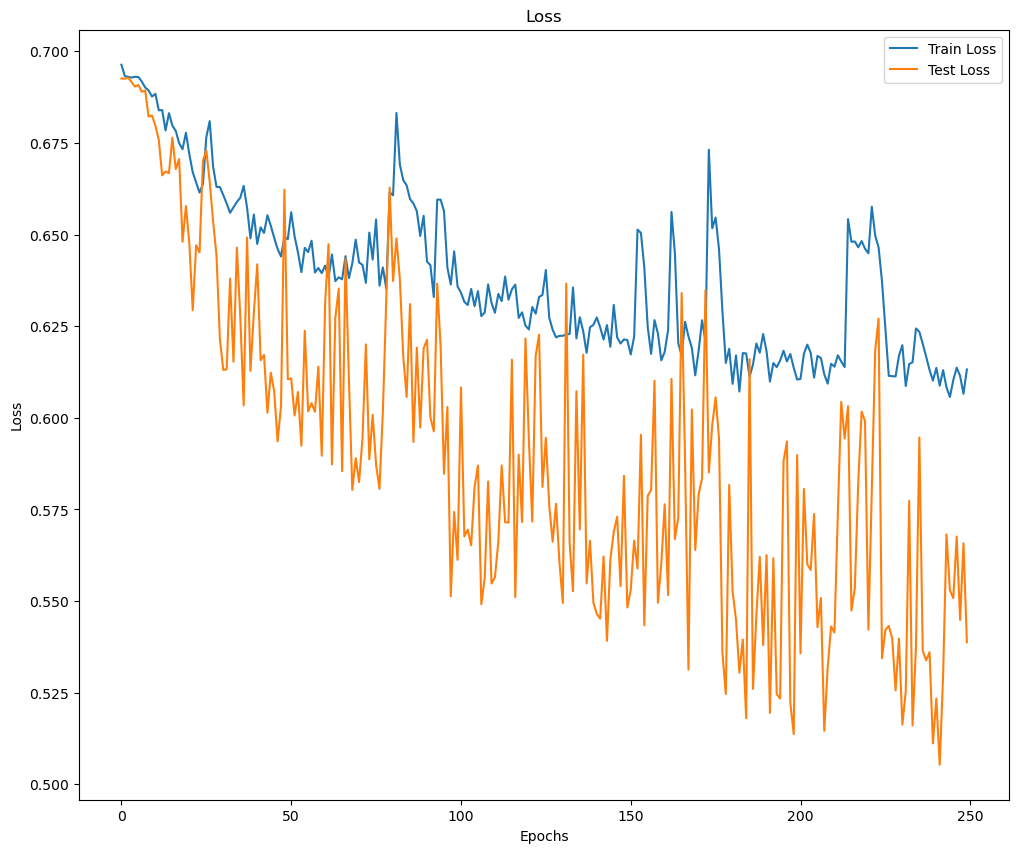

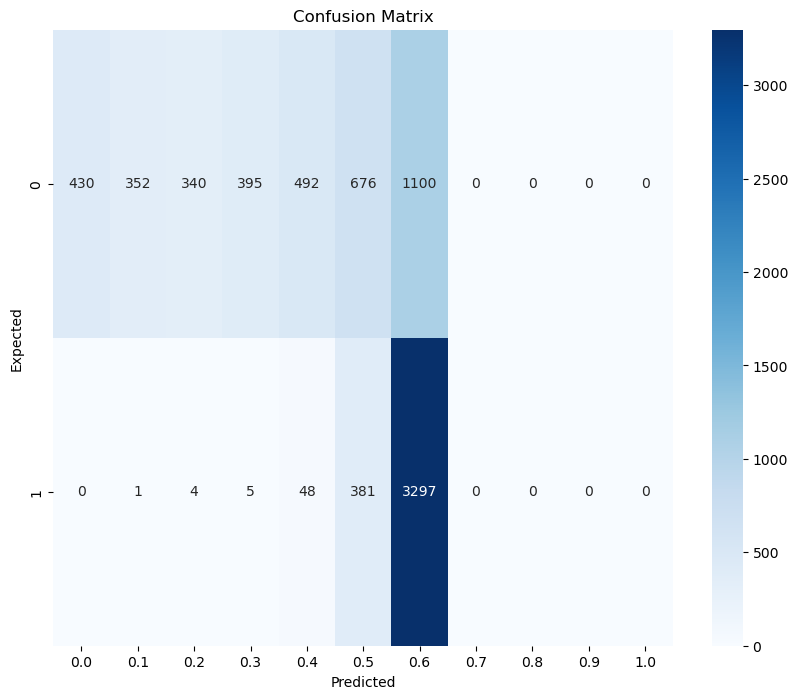

Variance of Predictions: 0.030947141349315643


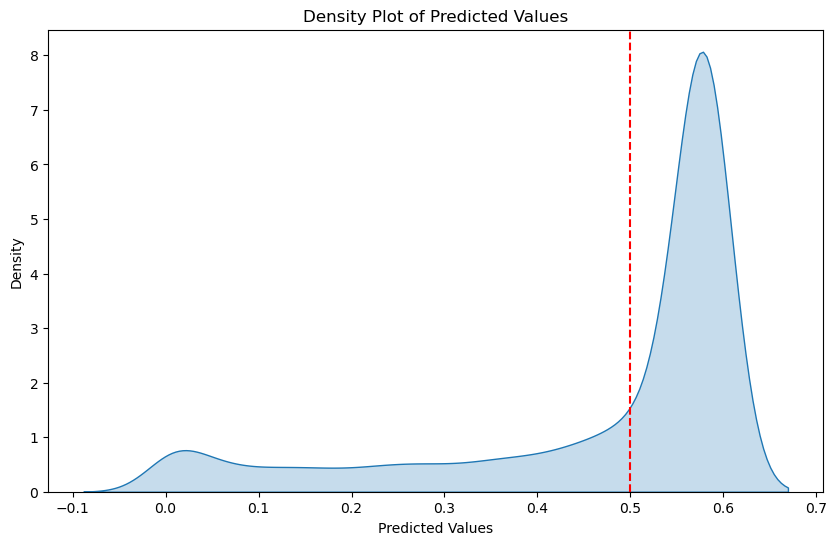

In [8]:
g_train_losses, g_test_losses, g_metrics = ft.train_model(
	model = g_model,
	train_loader = g_train_loader,
	test_loader = g_test_loader,
	loss_function = g_loss_function,
	optimizer = g_optimizer,
	metric_function = g_metric_function,
	epochs = g_epochs,
	debug_msg_interval = g_debug_msg_interval,
	early_stop_epochs = g_early_stop_epochs
)

if g_output_model_name.endswith('.pth'):
	tmp_model_name = g_output_model_name
else:
	tmp_model_name = f'{g_output_model_name}.pth'
print(f'Saving model to {tmp_model_name}')
torch.save(g_model.state_dict(), tmp_model_name)
# Plot Loss
x_axis = range(len(g_train_losses))
plt.figure(figsize=(12, 10))
plt.plot(x_axis, g_train_losses, label='Train Loss')
plt.plot(x_axis, g_test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
ft.plot_confusion_matrix(g_model,g_test_loader,num_separations=g_num_separations_confusion_matrix)
ft.plot_predictions_density(g_model, g_test_loader)

ft.del_tmp_vars()